In [4]:
import os
import numpy as np
import pandas as pd
import regex as re

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
pip install bracketology

  Created wheel for bracketology: filename=bracketology-0.0.99-py3-none-any.whl size=30416 sha256=20f684b89d4ebec4502ad45c4de3cd03b3ae4f2aadf973200731abd4cc65495e
  Stored in directory: /root/.cache/pip/wheels/ac/9e/6e/acfdd77b5a9406ac5ef7cfe513053c6ee00086b1cf1980d19a
Successfully built bracketology


# Creation of the Main Dataframe

In [7]:
heights = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/height21.csv")

In [8]:
miscDef = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/misc21Defense.csv")

In [9]:
miscOff = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/misc21Offense.csv")

In [10]:
miscOff=miscOff.add_prefix("Offensive_")
miscOff= miscOff.rename(columns={"Offensive_Season":"Season", "Offensive_TeamName":"TeamName"})

In [11]:
miscDef = miscDef.add_prefix("Defensive_")
miscDef = miscDef.rename(columns={"Defensive_Season":"Season","Defensive_TeamName":"TeamName"})

In [12]:
final_data_frame = pd.concat([miscOff,miscDef,heights],axis=1)

In [13]:
final_data_frame = final_data_frame.loc[:,~final_data_frame.columns.duplicated()]

# Main Functions

In [14]:
def clean_opponent_name(dataframe):
  clean_opponent_list = []
  pattern = r"[(\d)]"
  for team in dataframe.index:
    clean_opponent = re.sub(pattern,"",dataframe["Opponent"][team])
    clean_opponent = clean_opponent.replace("()","")
    if clean_opponent == "North Carolina State":
      clean_opponent = "N.C. State"
    if clean_opponent =="Florida State" or clean_opponent == "Florida State ":
      clean_opponent ="Florida St."
    
    clean_opponent = clean_opponent.strip()
    clean_opponent_list.append(clean_opponent)
  dataframe["Official Opponent"] = clean_opponent_list
  dataframe = dataframe.drop(columns=["Opponent"],axis=1)
  return dataframe

In [15]:
def grab_stats(offensive_factors, defensive_factors, team_name):
  offense_factors = offensive_factors[offensive_factors["TeamName"]== team_name]
  offense_factors = offense_factors.drop(["RankeFGPct","RankTOPct","RankORPct","RankFTRate","Season", "TeamName"],axis =1)
  defense_factors = defensive_factors[defensive_factors["TeamName"]== team_name]
  defense_factors = defense_factors.drop(["RankeFGPct","RankTOPct","RankORPct","RankFTRate","Season","TeamName"],axis =1)
  return offense_factors.values.tolist()[0], defense_factors.values.tolist()[0]

In [16]:
def grab_misc_stats(dataframe, team_name):
  dataframe = dataframe[dataframe.columns.drop(list(dataframe.filter(regex='Rank')))]
  misc_stats = dataframe[dataframe["TeamName"] == team_name]
  return misc_stats[["Exp","Bench","Size"]].values.tolist()

In [17]:
def return_final_dataframe(dataframe,team_name):
  offense_stats, defense_stats = grab_stats(offensive_four_factors_2020_2021,defensive_four_factors_2020_2021,team_name)
  tm_misc_stats = grab_misc_stats(final_data_frame,team_name)
  new_dataframe = dataframe[["Unnamed: 4","Official Opponent","Tm","Opp"]]
  new_dataframe[["Opp Off eFG%","Opp Off TOP%","Opp Off ORB%", "Opp Off FTR%"]] = np.NaN
  new_dataframe[["Opp Def eFG%","Opp Def TOP%","Opp Def ORB%", "Opp Def FTR%"]] = np.NaN
  for index,row in new_dataframe.iterrows():
    try:
      opponent_off_fac, opponent_def_fac = grab_stats(offensive_four_factors_2020_2021, defensive_four_factors_2020_2021, row["Official Opponent"])
      opponent_misc_stats = grab_misc_stats(final_data_frame, row["Official Opponent"])
      
      final_list = opponent_off_fac + opponent_def_fac + opponent_misc_stats[0]
      new_dataframe.at[ index, "Opp Off eFG%"] = final_list[0]
      new_dataframe.at[ index, "Opp Off TOP%"] = final_list[1]
      new_dataframe.at[ index, "Opp Off ORB%"] = final_list[2]
      new_dataframe.at[ index, "Opp Off FTR%"] = final_list[3]
      new_dataframe.at[ index, "Opp Def eFG%"] = final_list[4]
      new_dataframe.at[ index, "Opp Def TOP%"] = final_list[5]
      new_dataframe.at[ index, "Opp Def ORB%"] = final_list[6]
      new_dataframe.at[ index, "Opp Def FTR%"] = final_list[7]
      new_dataframe.at[ index, "Opp Exp"] = final_list[8]
      new_dataframe.at[ index, "Opp Bench"] = final_list[9]
      new_dataframe.at[ index, "Opp Size"] = final_list[10]
    except IndexError:
      continue
  total_stats = offense_stats + defense_stats + tm_misc_stats[0]
  new_dataframe["tm Off eFG%"] = total_stats[0]
  new_dataframe["tm Off TOP%"] = total_stats[1]
  new_dataframe["tm Off ORB%"] = total_stats[2]
  new_dataframe["tm Off FTR%"] = total_stats[3]
  new_dataframe["tm Def eFG%"] = total_stats[4]
  new_dataframe["tm Def TOP%"] = total_stats[5]
  new_dataframe["tm Def ORB%"] = total_stats[6]
  new_dataframe["tm Def FTR%"] = total_stats[7]
  new_dataframe["tm Exp"] = total_stats[8]
  new_dataframe["tm Bench"] = total_stats[9]
  new_dataframe["tm Size"] = total_stats[10]
  new_dataframe["Final Point Differential"] = new_dataframe["Tm"] - new_dataframe["Opp"]
  new_dataframe = new_dataframe.drop(columns=['Unnamed: 4','Official Opponent'])
  new_dataframe = new_dataframe.dropna()
  return new_dataframe

# ACC Table

In [18]:
UNC_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/UNC2020_2021.csv")
Duke_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Duke2020_2021.csv")
UVA_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/UVA2020_2021.csv")
NCState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/NCState2020_2021.csv")
BostonCollege_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/BostonCollege2020_2021.csv")
Clemson2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Clemson2020_2021.csv")
FloridaState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/FloridaState2020_2021.csv")
GeorgiaTech2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/GeorgiaTech2020_2021.csv")
Louisville2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Louisville2020_2021.csv")
Miami2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Miami2020_2021.csv")
Pittsburgh2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Pittsburgh2020_2021.csv")
Syracuse2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/Syracuse2020_2021.csv")
WakeForest2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/WakeForest2020_2021.csv")
VirginiaTech2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/ACC/VirginiaTech2020_2021.csv")

In [19]:
offensive_four_factors_2020_2021 = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/offense21.csv")
defensive_four_factors_2020_2021 = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/defense21.csv")

In [20]:
UNC_2020_2021_cleaned = clean_opponent_name(UNC_2020_2021_basic)
Duke_2020_2021_cleaned = clean_opponent_name(Duke_2020_2021_basic)
UVA_2020_2021_cleaned = clean_opponent_name(UVA_2020_2021_basic)
NCState_2020_2021_cleaned = clean_opponent_name(NCState_2020_2021_basic)
BostonCollege_2020_2021_cleaned = clean_opponent_name(BostonCollege_2020_2021_basic)
Clemson_2020_2021_cleaned = clean_opponent_name(Clemson2020_2021_basic)
FloridaState_2020_2021_cleaned = clean_opponent_name(FloridaState2020_2021_basic)
GeorgiaTech_2020_2021_cleaned = clean_opponent_name(GeorgiaTech2020_2021_basic)
Louisville_2020_2021_cleaned = clean_opponent_name(Louisville2020_2021_basic)
Miami_2020_2021_cleaned = clean_opponent_name(Miami2020_2021_basic)
Pittsburgh_2020_2021_cleaned = clean_opponent_name(Pittsburgh2020_2021_basic)
Syracuse_2020_2021_cleaned = clean_opponent_name(Syracuse2020_2021_basic)
WakeForest_2020_2021_cleaned = clean_opponent_name(WakeForest2020_2021_basic)
VirginiaTech_2020_2021_cleaned = clean_opponent_name(VirginiaTech2020_2021_basic)


# Big10

In [21]:
Illinois_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Illinois2020_2021.csv")
Indiana_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Indiana2020_2021csv.csv")
Iowa_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Iowa2020_2021.csv")
Maryland_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Maryland2020_2021.csv")
Michigan_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Michigan2020_2021.csv")
MichiganState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/MichiganState2020_2021.csv")
Minnesota2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Minnesota2020_2021.csv")
Nebraska2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Nebraska2020_2021.csv")
Northwestern2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Northwestern2020_2021.csv")
OhioState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/OhioState2020_2021.csv")
PennState2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/PennState2020_2021.csv")
Purdue2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Purdue2020_2021.csv")
Rutgers2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Rutgers2020_2021.csv")
Wisconsin2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big10/Wisconsin2020_2021.csv")

In [22]:
Illinois_2020_2021_cleaned = clean_opponent_name(Illinois_2020_2021_basic)
Indiana_2020_2021_cleaned = clean_opponent_name(Indiana_2020_2021_basic)
Iowa_2020_2021_cleaned = clean_opponent_name(Iowa_2020_2021_basic)
Maryland_2020_2021_cleaned = clean_opponent_name(Maryland_2020_2021_basic)
Michigan_2020_2021_cleaned = clean_opponent_name(Michigan_2020_2021_basic)
MichiganState2020_2021_cleaned = clean_opponent_name(MichiganState2020_2021_basic)
Minnesota2020_2021_cleaned = clean_opponent_name(Minnesota2020_2021_basic)
Nebraska2020_2021_cleaned = clean_opponent_name(Nebraska2020_2021_basic)
Northwestern2020_2021_cleaned = clean_opponent_name(Northwestern2020_2021_basic)
OhioState2020_2021_cleaned = clean_opponent_name(OhioState2020_2021_basic)
PennState2020_2021_cleaned = clean_opponent_name(PennState2020_2021_basic)
Purdue2020_2021_cleaned = clean_opponent_name(Purdue2020_2021_basic)
Rutgers2020_2021_cleaned = clean_opponent_name(Rutgers2020_2021_basic)
Wisconsin2020_2021_cleaned = clean_opponent_name(Wisconsin2020_2021_basic)

#Big12

In [23]:
Baylor_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/WestVirginia2020_2021.csv")
IowaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/IowaState2020_2021.csv")
Kansas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Kansas2020_2021.csv")
KansasState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/KansasState2020_2021.csv")
Oklahoma_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Oklahoma2020_2021.csv")
OklahomaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/OklahomaState2020_2021.csv")
TCU_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/TCU2020_2021.csv")
Texas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/Texas2020_2021.csv")
TexasTech_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/TexasTech2020_2021.csv")
WestVirginia_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Big12/WestVirginia2020_2021.csv")

In [24]:
Baylor_2020_2021_cleaned = clean_opponent_name(Baylor_2020_2021_basic)
IowaState_2020_2021_cleaned = clean_opponent_name(IowaState_2020_2021_basic)
Kansas_2020_2021_cleaned = clean_opponent_name(Kansas_2020_2021_basic)
KansasState_2020_2021_cleaned = clean_opponent_name(KansasState_2020_2021_basic)
Oklahoma_2020_2021_cleaned = clean_opponent_name(Oklahoma_2020_2021_basic)
OklahomaState_2020_2021_cleaned = clean_opponent_name(OklahomaState_2020_2021_basic)
TCU_2020_2021_cleaned = clean_opponent_name(TCU_2020_2021_basic)
Texas_2020_2021_cleaned = clean_opponent_name(Texas_2020_2021_basic)
TexasTech_2020_2021_cleaned = clean_opponent_name(TexasTech_2020_2021_basic)
WestVirginia_2020_2021_cleaned = clean_opponent_name(WestVirginia_2020_2021_basic)


# SEC

In [25]:
Alabama_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Alabama2020_2021.csv")
Arkansas_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Arkansas2020_2021.csv")
Auburn_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Auburn2020_2021.csv")
Kentucky_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Kentucky2020_2021.csv")
Florida_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Florida2020_2021.csv")
Georgia_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Georgia2020_2021.csv")
LSU_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/LSU2020_2021.csv")
MississippiState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/MississippiState2020_2021.csv")
Missouri_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Missouri2020_2021.csv")
oleMiss_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/oleMiss2020_2021.csv")
SouthCarolina_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/SouthCarolina2020_2021.csv")
Tennessee_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Tennessee2020_2021.csv")
TexasAM_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/TexasAM2020_2021.csv")
Vanderbilt_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/Southeastern/Vanderbilt2020_2021.csv")

In [26]:
Alabama_2020_2021_cleaned = clean_opponent_name(Alabama_2020_2021_basic)
Arkansas_2020_2021_cleaned = clean_opponent_name(Arkansas_2020_2021_basic)
Auburn_2020_2021_cleaned = clean_opponent_name(Auburn_2020_2021_basic)
Kentucky_2020_2021_cleaned = clean_opponent_name(Kentucky_2020_2021_basic)
Florida_2020_2021_cleaned = clean_opponent_name(Florida_2020_2021_basic)
Georgia_2020_2021_cleaned = clean_opponent_name(Georgia_2020_2021_basic)
LSU_2020_2021_cleaned = clean_opponent_name(LSU_2020_2021_basic)
MississippiState_2020_2021_cleaned = clean_opponent_name(MississippiState_2020_2021_basic)
Missouri_2020_2021_cleaned = clean_opponent_name(Missouri_2020_2021_basic)
oleMiss_2020_2021_cleaned = clean_opponent_name(oleMiss_2020_2021_basic)
SouthCarolina_2020_2021_cleaned = clean_opponent_name(SouthCarolina_2020_2021_basic)
Tennessee_2020_2021_cleaned = clean_opponent_name(Tennessee_2020_2021_basic)
TexasAM_2020_2021_cleaned = clean_opponent_name(TexasAM_2020_2021_basic)
Vanderbilt_2020_2021_cleaned = clean_opponent_name(Vanderbilt_2020_2021_basic)

# PAC-12

In [27]:
Arizona_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Arizona2020_2021.csv")
ArizonaState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/ArizonaState2020_2021.csv")
California_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/California2020_2021.csv")
ColoradoState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/ColoradoState2020_2021.csv")
Oregon_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Oregon2020_2021.csv")
OregonState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/OregonState2020_2021.csv")
Standford_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Standford2020_2021.csv")
UCLA_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/UCLA2020_2021.csv")
USC_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/USC2020_2021.csv")
Utah_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Utah2020_2021.csv")
Washington_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/Washington2020_2021.csv")
WashingtonState_2020_2021_basic = pd.read_csv("/content/drive/MyDrive/Capstone Project/Basketball Data/PAC12/WashingtonState2020_2021.csv")

In [28]:
Arizona_2020_2021_cleaned = clean_opponent_name(Arizona_2020_2021_basic)
ArizonaState_2020_2021_cleaned = clean_opponent_name(ArizonaState_2020_2021_basic)
California_2020_2021_cleaned = clean_opponent_name(California_2020_2021_basic)
ColoradoState_2020_2021_cleaned = clean_opponent_name(ColoradoState_2020_2021_basic)
Oregon_2020_2021_cleaned = clean_opponent_name(Oregon_2020_2021_basic)
OregonState_2020_2021_cleaned = clean_opponent_name(OregonState_2020_2021_basic)
Standford_2020_2021_cleaned = clean_opponent_name(Standford_2020_2021_basic)
UCLA_2020_2021_cleaned = clean_opponent_name(UCLA_2020_2021_basic)
USC_2020_2021_cleaned = clean_opponent_name(USC_2020_2021_basic)
Utah_2020_2021_cleaned = clean_opponent_name(Utah_2020_2021_basic)
Washington_2020_2021_cleaned = clean_opponent_name(Washington_2020_2021_basic)
WashingtonState_2020_2021_cleaned = clean_opponent_name(WashingtonState_2020_2021_basic)

# Final Dataframes

## ACC

In [29]:
UNC_2020_2021_FINAL = return_final_dataframe(UNC_2020_2021_cleaned,"North Carolina")
Duke_2020_2021_FINAL = return_final_dataframe(Duke_2020_2021_cleaned,"Duke")
UVA_2020_2021_FINAL = return_final_dataframe(UVA_2020_2021_cleaned,"Virginia")
NCState_2020_2021_FINAL = return_final_dataframe(NCState_2020_2021_cleaned,"N.C. State")
BostonCollege_2020_2021_FINAL = return_final_dataframe(BostonCollege_2020_2021_cleaned,"Boston College")
FloridaState_2020_2021_FINAL = return_final_dataframe(FloridaState2020_2021_basic,"Florida St.")
WakeForest_2020_2021_FINAL = return_final_dataframe(WakeForest_2020_2021_cleaned,"Wake Forest")
Clemson_2020_2021_FINAL = return_final_dataframe(Clemson_2020_2021_cleaned,"Clemson")
Pittsburgh_2020_2021_FINAL = return_final_dataframe(Pittsburgh_2020_2021_cleaned,"Pittsburgh")
GeorgiaTech_2020_2021_FINAL = return_final_dataframe(GeorgiaTech_2020_2021_cleaned,"Georgia Tech")
Miami_2020_2021_FINAL = return_final_dataframe(Miami_2020_2021_cleaned,"Miami FL")
Syracuse_2020_2021_FINAL = return_final_dataframe(Syracuse_2020_2021_cleaned,"Syracuse")
VirginiaTech_2020_2021_FINAL = return_final_dataframe(VirginiaTech_2020_2021_cleaned,"Virginia Tech")
Louisville_2020_2021_FINAL = return_final_dataframe(Louisville_2020_2021_cleaned,"Louisville")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Big10

In [30]:
Illinois_2020_2021_FINAL = return_final_dataframe(Illinois_2020_2021_cleaned,"Illinois")
Indiana_2020_2021_FINAL = return_final_dataframe(Indiana_2020_2021_cleaned,"Indiana")
Iowa_2020_2021_FINAL = return_final_dataframe(Iowa_2020_2021_cleaned,"Iowa")
Maryland_2020_2021_FINAL = return_final_dataframe(Maryland_2020_2021_cleaned,"Maryland")
Michigan_2020_2021_FINAL = return_final_dataframe(Michigan_2020_2021_cleaned,"Michigan")
MichiganState2020_2021_FINAL = return_final_dataframe(MichiganState2020_2021_cleaned,"Michigan St.")
Minnesota2020_2021_FINAL = return_final_dataframe(Minnesota2020_2021_cleaned,"Minnesota")
Nebraska2020_2021_FINAL = return_final_dataframe(Nebraska2020_2021_cleaned,"Nebraska")
Northwestern2020_2021_FINAL = return_final_dataframe(Northwestern2020_2021_cleaned,"Northwestern")
OhioState2020_2021_FINAL = return_final_dataframe(OhioState2020_2021_cleaned,"Ohio St.")
PennState2020_2021_FINAL = return_final_dataframe(PennState2020_2021_cleaned,"Penn St.")
Purdue2020_2021_FINAL = return_final_dataframe(Purdue2020_2021_cleaned,"Purdue")
Rutgers2020_2021_FINAL = return_final_dataframe(Rutgers2020_2021_cleaned,"Rutgers")
Wisconsin2020_2021_FINAL = return_final_dataframe(Wisconsin2020_2021_cleaned,"Wisconsin")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Big12

In [31]:
Baylor_2020_2021_FINAL = return_final_dataframe(Baylor_2020_2021_cleaned,"Baylor")
IowaState_2020_2021_FINAL = return_final_dataframe(IowaState_2020_2021_cleaned,"Iowa St.")
Kansas_2020_2021_FINAL = return_final_dataframe(Kansas_2020_2021_cleaned,"Kansas")
KansasState_2020_2021_FINAL = return_final_dataframe(KansasState_2020_2021_cleaned,"Kansas St.")
Oklahoma_2020_2021_FINAL = return_final_dataframe(Oklahoma_2020_2021_cleaned,"Oklahoma")
OklahomaState_2020_2021_FINAL = return_final_dataframe(OklahomaState_2020_2021_cleaned,"Oklahoma St.")
TCU_2020_2021_FINAL = return_final_dataframe(TCU_2020_2021_cleaned,"TCU")
Texas_2020_2021_FINAL = return_final_dataframe(Texas_2020_2021_cleaned,"Texas")
TexasTech_2020_2021_FINAL = return_final_dataframe(TexasTech_2020_2021_cleaned,"Texas Tech")
WestVirginia_2020_2021_FINAL = return_final_dataframe(WestVirginia_2020_2021_cleaned,"West Virginia")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## SEC

In [32]:
Alabama_2020_2021_FINAL = return_final_dataframe(Alabama_2020_2021_cleaned,"Alabama")
Arkansas_2020_2021_FINAL = return_final_dataframe(Arkansas_2020_2021_cleaned,"Arkansas")
Auburn_2020_2021_FINAL = return_final_dataframe(Auburn_2020_2021_cleaned,"Auburn")
Kentucky_2020_2021_FINAL = return_final_dataframe(Kentucky_2020_2021_cleaned,"Kentucky")
Florida_2020_2021_FINAL = return_final_dataframe(Florida_2020_2021_cleaned,"Florida")
Georgia_2020_2021_FINAL = return_final_dataframe(Georgia_2020_2021_cleaned,"Georgia")
LSU_2020_2021_FINAL = return_final_dataframe(LSU_2020_2021_cleaned,"LSU")
MississippiState_2020_2021_FINAL = return_final_dataframe(MississippiState_2020_2021_cleaned,"Mississippi St.")
Missouri_2020_2021_FINAL = return_final_dataframe(Missouri_2020_2021_cleaned,"Missouri")
oleMiss_2020_2021_FINAL = return_final_dataframe(oleMiss_2020_2021_cleaned,"Mississippi")
SouthCarolina_2020_2021_FINAL = return_final_dataframe(SouthCarolina_2020_2021_cleaned,"South Carolina")
Tennessee_2020_2021_FINAL = return_final_dataframe(Tennessee_2020_2021_cleaned,"Tennessee")
TexasAM_2020_2021_FINAL = return_final_dataframe(TexasAM_2020_2021_cleaned,"Texas A&M")
Vanderbilt_2020_2021_FINAL = return_final_dataframe(Vanderbilt_2020_2021_cleaned,"Vanderbilt")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## PAC-12

In [33]:
Arizona_2020_2021_FINAL = return_final_dataframe(Arizona_2020_2021_cleaned,"Arizona")
ArizonaState_2020_2021_FINAL = return_final_dataframe(ArizonaState_2020_2021_cleaned,"Arizona St.")
California_2020_2021_FINAL = return_final_dataframe(California_2020_2021_cleaned,"California")
ColoradoState_2020_2021_FINAL = return_final_dataframe(ColoradoState_2020_2021_cleaned,"Colorado St.")
Oregon_2020_2021_FINAL = return_final_dataframe(Oregon_2020_2021_cleaned,"Oregon")
OregonState_2020_2021_FINAL = return_final_dataframe(OregonState_2020_2021_cleaned,"Oregon St.")
Standford_2020_2021_FINAL = return_final_dataframe(Standford_2020_2021_cleaned,"Stanford")
UCLA_2020_2021_FINAL = return_final_dataframe(UCLA_2020_2021_cleaned,"UCLA")
USC_2020_2021_FINAL = return_final_dataframe(USC_2020_2021_cleaned,"USC")
Utah_2020_2021_FINAL = return_final_dataframe(Utah_2020_2021_cleaned,"Utah")
Washington_2020_2021_FINAL = return_final_dataframe(Washington_2020_2021_cleaned,"Washington")
WashingtonState_2020_2021_FINAL = return_final_dataframe(WashingtonState_2020_2021_cleaned,"Washington St.")

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

# Team Names

In [34]:
ACC = ["UNC","UVA","Duke","Louisville","WakeForest","Clemson","Pittsburgh","Syracuse","Clemson","FloridaState","Miami","BostonCollege","GeorgiaTech","VirginiaTech"]
Big10 = ["Illinois","Indiana","Iowa","Maryland","Michigan","MichiganState","Minnesota","Nebraska","Northwestern","OhioState","PennState","Purdue","Rutgers","Wisconsin"]
Big12 = ["Baylor","Iowa State","Kansas","Kansas State","Oklahoma","Oklahoma State","TCU","Texas","Texas Tech","West Virginia"]
SEC = ["Alabama","Arkansas","Auburn","Kentucky","Florida","Georgia","LSU","Mississippi State","Missouri","Ole Miss","South Carolina","Tennessee","Texas A&M","Vanderbilt"]
PAC12=  ["Arizona","Arizona State","California","Colorado State","Oregon","Oregon State","Stanford","UCLA","USC","Utah","Washington","Washington State"]

In [35]:
final_team_names = ACC + Big10 + Big12 + SEC + PAC12

# Final Dataframes

In [36]:
list_of_final_dataframes = []
list_of_final_dataframes.append(UNC_2020_2021_FINAL)
list_of_final_dataframes.append(UVA_2020_2021_FINAL)
list_of_final_dataframes.append(Duke_2020_2021_FINAL)
list_of_final_dataframes.append(Louisville_2020_2021_FINAL)
list_of_final_dataframes.append(WakeForest_2020_2021_FINAL)
list_of_final_dataframes.append(Clemson_2020_2021_FINAL)
list_of_final_dataframes.append(Pittsburgh_2020_2021_FINAL)
list_of_final_dataframes.append(Syracuse_2020_2021_FINAL)
list_of_final_dataframes.append(Clemson_2020_2021_FINAL)
list_of_final_dataframes.append(FloridaState_2020_2021_FINAL)
list_of_final_dataframes.append(Miami_2020_2021_FINAL)
list_of_final_dataframes.append(BostonCollege_2020_2021_FINAL)
list_of_final_dataframes.append(GeorgiaTech_2020_2021_FINAL)
list_of_final_dataframes.append(VirginiaTech_2020_2021_FINAL)

list_of_final_dataframes.append(Illinois_2020_2021_FINAL)
list_of_final_dataframes.append(Indiana_2020_2021_FINAL)
list_of_final_dataframes.append(Iowa_2020_2021_FINAL)
list_of_final_dataframes.append(Maryland_2020_2021_FINAL)
list_of_final_dataframes.append(Michigan_2020_2021_FINAL)
list_of_final_dataframes.append(MichiganState2020_2021_FINAL)
list_of_final_dataframes.append(Minnesota2020_2021_FINAL)
list_of_final_dataframes.append(Nebraska2020_2021_FINAL)
list_of_final_dataframes.append(Northwestern2020_2021_FINAL)
list_of_final_dataframes.append(OhioState2020_2021_FINAL)
list_of_final_dataframes.append(PennState2020_2021_FINAL)
list_of_final_dataframes.append(Purdue2020_2021_FINAL)
list_of_final_dataframes.append(Rutgers2020_2021_FINAL)
list_of_final_dataframes.append(Wisconsin2020_2021_FINAL)

list_of_final_dataframes.append(Baylor_2020_2021_FINAL)
list_of_final_dataframes.append(IowaState_2020_2021_FINAL)
list_of_final_dataframes.append(Kansas_2020_2021_FINAL)
list_of_final_dataframes.append(KansasState_2020_2021_FINAL)
list_of_final_dataframes.append(Oklahoma_2020_2021_FINAL)
list_of_final_dataframes.append(OklahomaState_2020_2021_FINAL)
list_of_final_dataframes.append(TCU_2020_2021_FINAL)
list_of_final_dataframes.append(Texas_2020_2021_FINAL)
list_of_final_dataframes.append(TexasTech_2020_2021_FINAL)
list_of_final_dataframes.append(WestVirginia_2020_2021_FINAL)

list_of_final_dataframes.append(Alabama_2020_2021_FINAL)
list_of_final_dataframes.append(Arkansas_2020_2021_FINAL)
list_of_final_dataframes.append(Auburn_2020_2021_FINAL)
list_of_final_dataframes.append(Kentucky_2020_2021_FINAL)
list_of_final_dataframes.append(Florida_2020_2021_FINAL)
list_of_final_dataframes.append(Georgia_2020_2021_FINAL)
list_of_final_dataframes.append(LSU_2020_2021_FINAL)
list_of_final_dataframes.append(MississippiState_2020_2021_FINAL)
list_of_final_dataframes.append(Missouri_2020_2021_FINAL)
list_of_final_dataframes.append(oleMiss_2020_2021_FINAL)
list_of_final_dataframes.append(SouthCarolina_2020_2021_FINAL)
list_of_final_dataframes.append(Tennessee_2020_2021_FINAL)
list_of_final_dataframes.append(TexasAM_2020_2021_FINAL)
list_of_final_dataframes.append(Vanderbilt_2020_2021_FINAL)

list_of_final_dataframes.append(Arizona_2020_2021_FINAL)
list_of_final_dataframes.append(ArizonaState_2020_2021_FINAL)
list_of_final_dataframes.append(California_2020_2021_FINAL)
list_of_final_dataframes.append(ColoradoState_2020_2021_FINAL)
list_of_final_dataframes.append(Oregon_2020_2021_FINAL)
list_of_final_dataframes.append(OregonState_2020_2021_FINAL)
list_of_final_dataframes.append(Standford_2020_2021_FINAL)
list_of_final_dataframes.append(UCLA_2020_2021_FINAL)
list_of_final_dataframes.append(USC_2020_2021_FINAL)
list_of_final_dataframes.append(Utah_2020_2021_FINAL)
list_of_final_dataframes.append(Washington_2020_2021_FINAL)
list_of_final_dataframes.append(WashingtonState_2020_2021_FINAL)

# Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [38]:
def perform_linear_regression(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  lin_reg = LinearRegression()
  lin_reg.fit(x,y)
  basketball_predictions = lin_reg.predict(x)
  lin_mse = mean_squared_error(y, basketball_predictions)
  lin_rmse = np.sqrt(lin_mse)
  return lin_rmse

In [39]:
linear_errors = []
for i in range(len(list_of_final_dataframes)):
  linear_errors.append(perform_linear_regression(list_of_final_dataframes[i]))
linear_errors

[1.324632795170644e-14,
 2.136967039781556e-14,
 1.491077346820111e-14,
 3.018941182079871e-14,
 1.7885620565660124e-14,
 1.3442527016528515e-14,
 1.191939596361987e-14,
 2.2088270359552614e-14,
 1.3442527016528515e-14,
 7.0001559474788026e-15,
 1.0020515146095616e-14,
 1.1702403733693673e-14,
 1.244022389839976e-14,
 1.0739248779282092e-14,
 8.93099113419185e-15,
 1.5151188845081247e-14,
 2.493235635302362e-14,
 1.5479551025817328e-14,
 9.510838578450519e-15,
 1.6106231118193916e-14,
 1.1862034989596916e-14,
 1.4601980456079796e-14,
 1.3265619603787059e-14,
 1.3133833583852351e-14,
 2.2524124170991938e-14,
 2.25921519920002e-14,
 1.709983749051206e-14,
 5.863252328668063e-15,
 1.66162967242209e-14,
 9.330678329323155e-15,
 7.648337741139753e-15,
 1.480556395542867e-14,
 1.6250734088796027e-14,
 1.9026644469968422e-14,
 4.5183030933119236e-14,
 2.52987973581614e-14,
 1.7161237463612905e-14,
 1.3759600911837627e-14,
 1.967966426208804e-14,
 1.630599791808959e-14,
 1.4491801241121534e-14

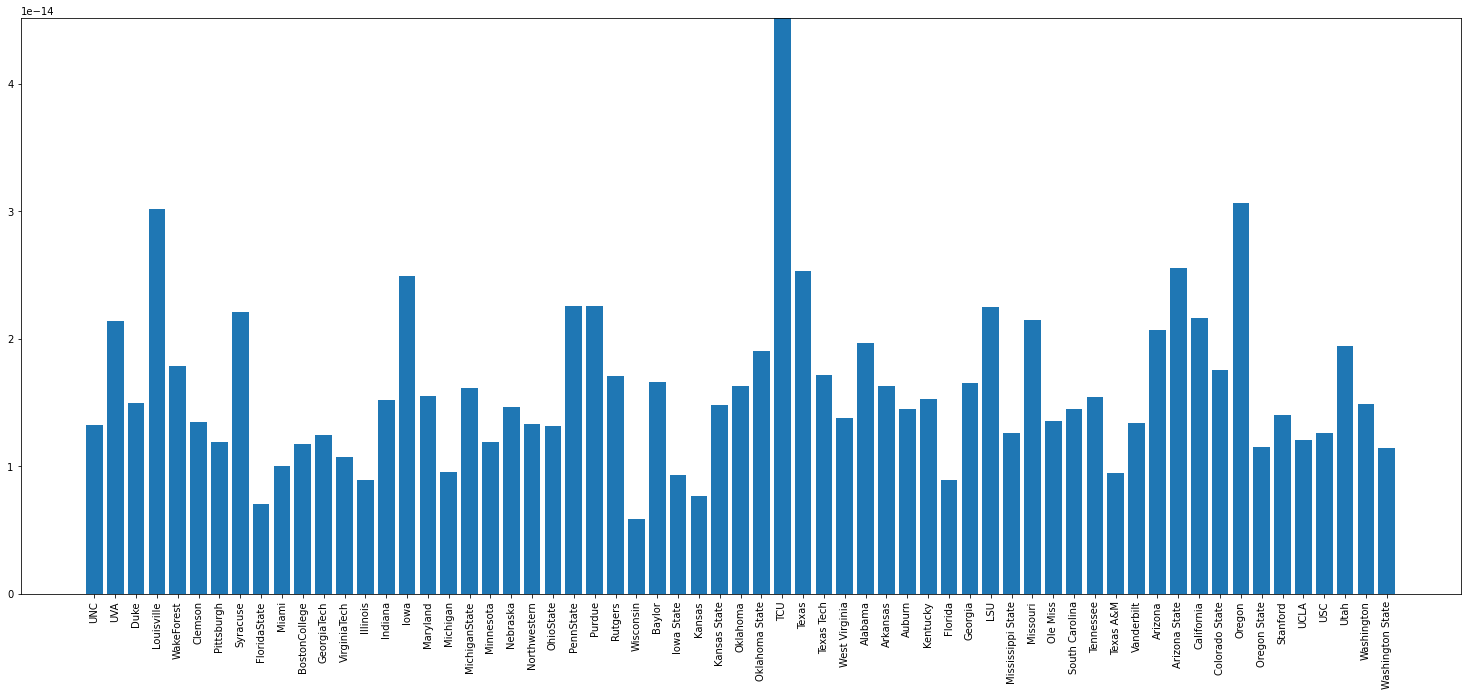

In [40]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
plt.bar(final_team_names ,linear_errors)
low = 0
high = max(linear_errors)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.show()

In [41]:
def perform_linear_regression(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  lin_reg = LinearRegression()
  lin_reg.fit(x,y)
  basketball_predictions = lin_reg.predict(x)
  lin_mse = mean_squared_error(y, basketball_predictions)
  lin_rmse = np.sqrt(lin_mse)
  return lin_rmse, basketball_predictions, y

In [42]:
final_table = pd.concat(list_of_final_dataframes)

In [43]:
final_table

,Tm,Opp,Opp Off eFG%,Opp Off TOP%,Opp Off ORB%,Opp Off FTR%,Opp Def eFG%,Opp Def TOP%,Opp Def ORB%,Opp Def FTR%,Opp Exp,Opp Bench,Opp Size,tm Off eFG%,tm Off TOP%,tm Off ORB%,tm Off FTR%,tm Def eFG%,tm Def TOP%,tm Def ORB%,tm Def FTR%,tm Exp,tm Bench,tm Size,Final Point Differential
2,67.0,63.0,51.368925,21.034501,25.059952,36.481862,48.259789,20.251579,28.688525,27.035426,1.34,37.96,78.80,48.302300,20.347544,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,4.0
3,67.0,69.0,52.876535,20.672106,31.122995,33.872010,46.041799,17.779064,27.458617,35.908803,1.96,27.83,77.84,48.302300,20.347544,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-2.0
4,80.0,93.0,54.742478,13.334165,30.803177,31.973483,48.826174,16.100777,29.099678,22.177822,1.70,30.77,77.91,48.302300,20.347544,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,-13.0
5,73.0,67.0,46.870654,21.392449,26.406926,34.492350,51.035912,20.838240,33.561644,38.259669,2.61,39.50,75.20,48.302300,20.347544,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,6.0
6,75.0,63.0,47.086721,19.756581,32.644178,34.485095,46.679816,17.945089,30.522946,29.651545,1.00,31.72,78.95,48.302300,20.347544,40.913160,34.173056,49.106113,19.048764,26.404494,26.874279,1.02,34.83,78.84,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,74.0,71.0,54.237288,16.737499,29.120879,25.968523,50.763845,20.200430,27.650273,26.670910,2.32,28.50,77.51,47.888239,21.598329,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,3.0
19,81.0,73.0,52.021563,15.685911,30.451128,31.590296,50.414136,17.495823,25.070159,28.161237,1.38,27.39,77.29,47.888239,21.598329,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,8.0
21,63.0,65.0,48.876404,19.228946,23.355263,26.239260,51.200253,17.224803,34.357849,34.680985,1.91,33.18,77.77,47.888239,21.598329,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,-2.0
23,85.0,76.0,51.368925,21.034501,25.059952,36.481862,48.259789,20.251579,28.688525,27.035426,1.34,37.96,78.80,47.888239,21.598329,30.676085,34.697856,46.613419,18.497839,25.971370,32.715655,1.05,39.38,78.77,9.0


In [44]:
lin_rmse, basketball_predictions, y = perform_linear_regression(final_table)

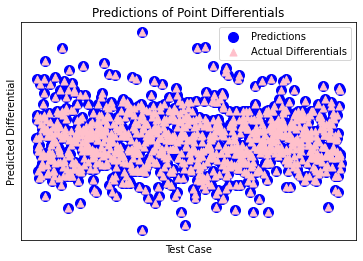

In [45]:
import matplotlib.pyplot as plt
plt.scatter([x for x in range(len(y))], basketball_predictions, color="blue", marker="o", s=100)
plt.scatter([x for x in range(len(y))], y, color="pink", marker="^", s=50)
#plt.scatter([x for x in range(5)], basketball_predictions, color="blue", marker="o", s=100)
plt.xticks(())
plt.yticks(())
plt.xlabel("Test Case")
plt.ylabel("Predicted Differential")
plt.title("Predictions of Point Differentials")
plt.legend(['Predictions', 'Actual Differentials'])
plt.show()

# Decision Trees

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor(random_state=2)

In [47]:
def perform_tree(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  tree_reg.fit(x,y)
  scores = cross_val_score(tree_reg, x, y,
                         scoring="neg_mean_squared_error", cv=4)
  tree_rmse_scores = np.sqrt(-scores)
  return tree_rmse_scores

In [48]:
average_tree_rmse = []
for i in range(len(list_of_final_dataframes)):
  tree_rmse = perform_tree(list_of_final_dataframes[i])
  average_tree_rmse.append(np.mean(tree_rmse[0]))

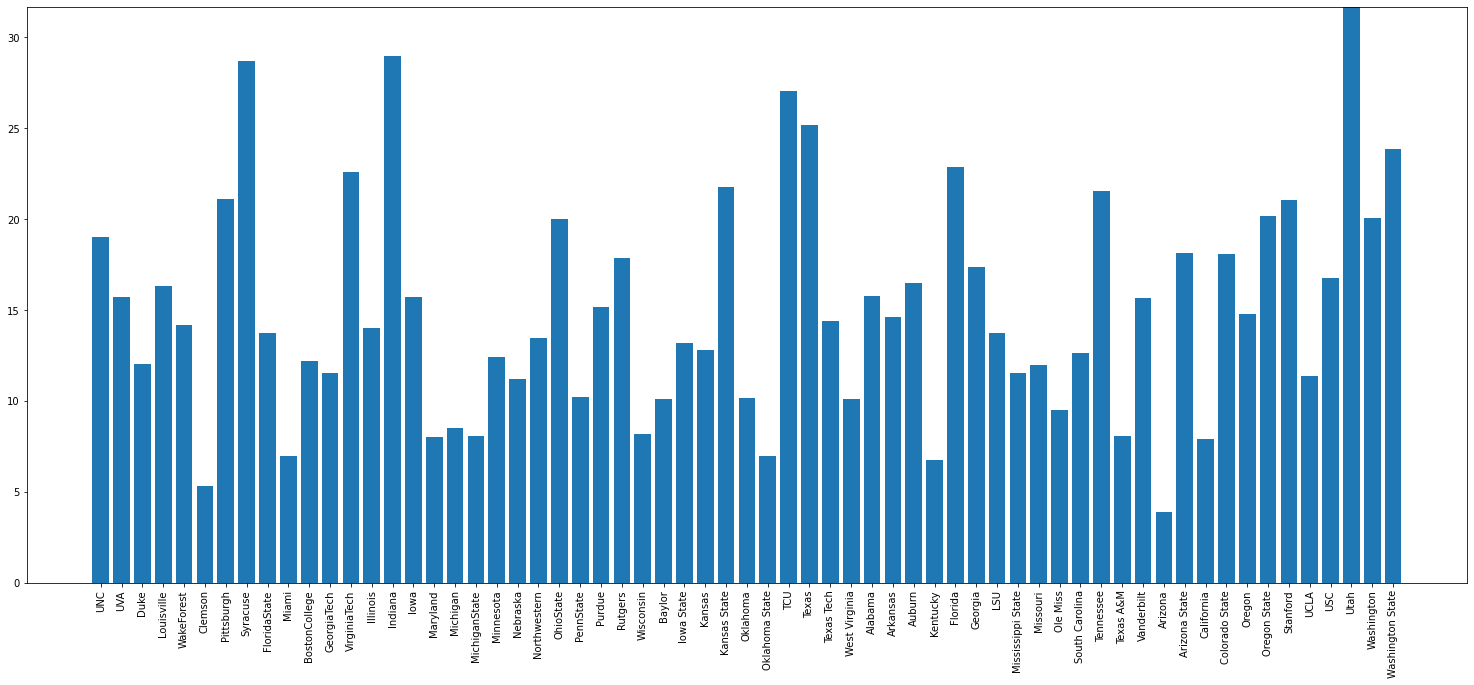

In [49]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
plt.bar(final_team_names,average_tree_rmse)
low = 0
high = max(average_tree_rmse)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.show()

# Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
def perform_random_forest(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["Final Point Differential"].copy()
  x = train_set.drop(columns="Final Point Differential")
  y_test = test_set["Final Point Differential"].copy()
  x_test = test_set.drop(columns="Final Point Differential")
  random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
  random_forest_reg.fit(x,y)
  random_forest_predictions = random_forest_reg.predict(x)
  random_tree_mse = mean_squared_error(y,random_forest_predictions)
  random_tree_rmse = np.sqrt(random_tree_mse)
  return random_tree_rmse

In [51]:

random_forest_errors = []
for i in range(len(list_of_final_dataframes)):
  random_forest_errors.append(perform_random_forest(list_of_final_dataframes[i]))
random_forest_errors

[5.166810289862458,
 4.180623956620192,
 2.475454800756466,
 4.495078049007233,
 4.121575851540282,
 4.265424949521442,
 4.045169959346579,
 5.018374808071405,
 4.265424949521442,
 3.5496213551174556,
 3.0343227062582327,
 5.048278914640118,
 3.424174677527743,
 5.422074633692654,
 5.886470834794723,
 4.789266645322642,
 3.392910255223383,
 3.6202127009334686,
 3.3099405835553406,
 3.999532867460241,
 4.733651644844268,
 3.8001766876216236,
 4.291615259836504,
 2.5709704177389687,
 4.802823388383129,
 4.7445857300717,
 4.447744122336375,
 3.671433106108782,
 3.763027627200858,
 3.181240467033404,
 4.1545933800850054,
 4.157899538400197,
 3.385782491082833,
 2.8477041191106913,
 5.468159349055828,
 4.30377063360336,
 4.428014039423694,
 3.763027627200858,
 5.087351704808805,
 5.413492865054872,
 4.128584637755549,
 3.7180572884236196,
 4.2294128828163995,
 5.384796134652147,
 4.990825082088131,
 3.7638356886172772,
 3.1657059430160372,
 2.7887654078462747,
 3.7697025271043794,
 5.515351

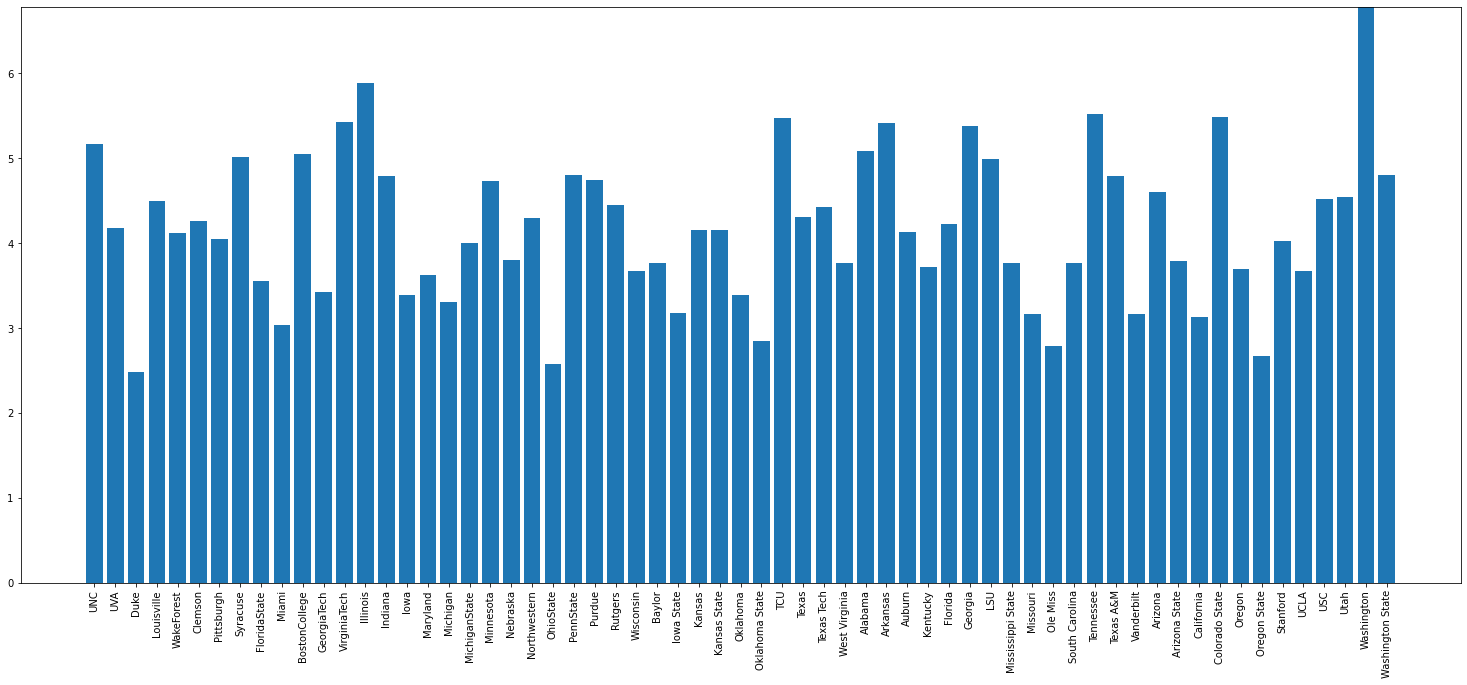

In [52]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(1, [20,8])
ax = fig.add_axes([0,0,1,1])
plt.bar(final_team_names,random_forest_errors)
low = 0
high = max(random_forest_errors)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.ylim([0, high])
plt.show()

# Log Reg

In [53]:
list_log_dataframes = []
for i in range(len(list_of_final_dataframes)):
  log_dataframe = list_of_final_dataframes[i]
  log_dataframe['BinaryResult'] = np.where(log_dataframe['Final Point Differential'] > 0 , 1, 0)
  list_log_dataframes.append(log_dataframe)

In [54]:


def perform_log(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["BinaryResult"].copy()
  x = train_set.drop(columns="BinaryResult")

  log_reg = LogisticRegressionCV(cv=3,random_state=0, max_iter=1000).fit(x,y)

  
  log_basketball_predictions = log_reg.predict(x)

  log_mse = log_loss(y, log_basketball_predictions)
  return log_mse

In [55]:
from sklearn.metrics import f1_score
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV
def perform_log(df):
  train_set, test_set = train_test_split(df,test_size = 0.2, random_state = 9)
  y = train_set["BinaryResult"].copy()
  x = train_set.drop(columns="BinaryResult")
  
  log_reg = LogisticRegressionCV(cv=4,random_state=0, max_iter=1000).fit(x,y)

  
  log_basketball_predictions = log_reg.predict(x)
  scores = f1_score(y, log_basketball_predictions)
  log_mse = log_loss(y, log_basketball_predictions)
  return log_mse , scores


In [56]:
log_reg_errors = []
f1_scores_list = []
for i in range(len(list_log_dataframes)):
  if(i == 29):
    continue
  log_error, values= perform_log(list_log_dataframes[i])
  log_reg_errors.append(log_error)
  f1_scores_list.append(values)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selecti

In [57]:
np.mean(f1_scores_list)

0.9465498427779552

In [58]:
np.mean(log_reg_errors)

0.607086087567961

# Bracketology

In [59]:
from bracketology import Bracket, Game, Team

In [60]:
year = 2019
b19 = Bracket(year)

## Test

In [70]:
import random
def pick_a_random_team(the_game):

    # Extract Teams from Game
    team1 = the_game.top_team
    team2 = the_game.bottom_team

    # Randomly select a winner
    if random.random() < 0.5:
        winner = team1
    else:
        winner = team2

    # Return the lucky team
    return winner

In [ ]:
def linear_pick(the_game):
    team1 = the_game.top_team
    team2 = the_game.bottom_team


    

In [71]:
# Initialize simulation parameters
n_sims = 1000 # number of times to simulate through all years
brackets = [b19]
total_sims = (n_sims * len(brackets))
scores = []
correct_games = []

# Loop through a plethora of brackets
for i in range(n_sims):
    for bracket in brackets:

        # Run the algorithm on the bracket
        bracket.score(sim_func=pick_a_random_team, verbose=False)

        # Save the scoring results in a list
        scores.append(bracket.total_score)
        correct_games.append(bracket.n_games_correct)

# Calculate the average across all simulations
avg_score = round(sum(scores) / total_sims)
avg_correct = round(sum(correct_games) / total_sims)

# Print result
print(f"Average number total score {avg_score}/192")
print(f"Average number of games guessed correctly {avg_correct}/64")

Average number total score 31/192
Average number of games guessed correctly 21/64
